In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
import numpy as np
import matplotlib.pyplot as plt

# from tsl.metrics.torch import MaskedMAE
# from tsl.engines import Predictor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from einops import rearrange
from tqdm import tqdm

from dataset.utils import process_PVUS

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


# Load & process dataset

for more datasets:

https://github.com/dtortorella/dyngraphesn/tree/master

In [2]:
config = {
        'reservoir_size': 170,
        'input_scaling': 0.84,
        'reservoir_layers': 6,
        'leaking_rate': 0.17,
        'spectral_radius': 4.85,
        'density': 0.41,
        'reservoir_activation': 'relu',
        'alpha_decay': False
    }

In [3]:
train_dataloader, test_dataloader, val_dataloader = process_PVUS(config, device, ignore_file=False, verbose=True)

# Train the readout

In [4]:
class LinearRegression(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('test_loss', loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer


In [5]:
forecaster = LinearRegression(input_size=config['reservoir_size'],
                              output_size=1).to(device)

In [6]:
logger = TensorBoardLogger(save_dir="logs", name="dynGESN", version=0)
# %load_ext tensorboard
# %tensorboard --logdir logs

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
                    # fast_dev_run=True,
                    max_epochs=500,
                    logger=logger,
                    # profiler="simple",
                    # limit_train_batches=0.1, 
                    # limit_val_batches=0.1,
                    devices=1, 
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    # limit_train_batches=50,  # end an epoch after 10 updates
                    # limit_val_batches=50,  # end an epoch after 10 updates
                    callbacks=[checkpoint_callback, early_stop_callback])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=forecaster, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:634: Checkpoint directory logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 171   
----------------------------------
171       Trainable params
0         Non-trainable params
171       Total params
0.001     Total estimated model params size (MB)


c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 45: 100%|██████████| 192/192 [00:01<00:00, 127.43it/s, v_num=0]


In [8]:
torch.save(forecaster.state_dict(), "models/dynGESN_readout.pt")

In [7]:
# Specify the path to the saved model
model_path = "models/saved/dynGESN_readout.pt"

# Create an instance of the LinearRegression model
loaded_model = LinearRegression(input_size=config['reservoir_size'], output_size=1).to(device)

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()

LinearRegression(
  (linear): Linear(in_features=170, out_features=1, bias=True)
)

In [24]:
test_x, test_y = next(iter(test_dataloader))
test_x = test_x[0,:,:].to(device)
test_y = test_y[0,:,:].to(device)

In [26]:
output = loaded_model(test_x)

In [8]:
next(iter(test_dataloader))[0].shape

torch.Size([1, 200, 170])

In [13]:
# Set the model to evaluation mode
loaded_model = forecaster
loaded_model.to(device).eval()

outputs = []
targets = []

for test_sample in tqdm(test_dataloader):
    test_x, test_y = test_sample[0].to(device), test_sample[1].to(device)
    output = loaded_model(test_x).squeeze()

    outputs.append(output)
    targets.append(test_y)
    if len(outputs) >= 25:
        break

stacked_outputs = torch.stack(outputs, dim=0)
stacked_targets = torch.stack(targets, dim=0).squeeze()

 86%|████████▌ | 24/28 [00:00<00:00, 139.72it/s]


In [14]:
stacked_outputs.shape

torch.Size([25, 32, 200])

In [15]:
stacked_targets.shape

torch.Size([25, 32, 200])

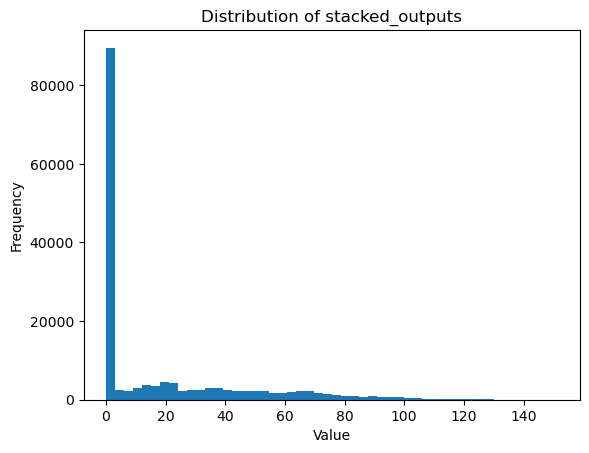

In [16]:
plt.hist(stacked_outputs.flatten().cpu().detach().numpy(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of stacked_outputs')
plt.show()


In [22]:
nonzero_indices = torch.nonzero(stacked_targets[:, 0, :, :, 0])
print(nonzero_indices)

tensor([[ 18,  23, 181],
        [ 18,  23, 193],
        [ 18,  23, 211],
        ...,
        [ 99,  12, 929],
        [ 99,  12, 931],
        [ 99,  13, 924]], device='cuda:0')


In [27]:
stacked_targets[99, 0,:,929,0]

tensor([20.3000, 19.9500, 19.9500, 19.3500, 18.8000, 18.2000, 17.0500, 15.6500,
        14.5500, 13.4000, 10.4500,  6.2500,  1.8500,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

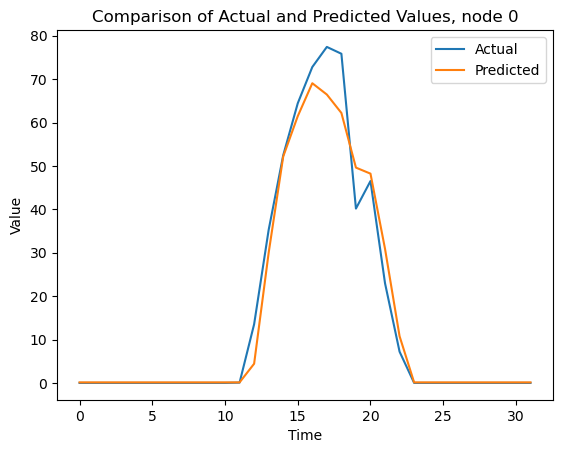

In [17]:
node_id = 0

plt.plot(stacked_targets[0,:,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(stacked_outputs[0,:,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

In [179]:
X = []
Y = []

for test_sample in tqdm(test_dataloader):
    test_x, test_y = test_sample[0][:].to(device), test_sample[1][:].to(device)
    X.append(test_x)
    Y.append(test_y)
    
    if len(X) >= 27:
        break

X = torch.cat(X, dim=0)
Y = torch.cat(Y, dim=0).squeeze()

 93%|█████████▎| 26/28 [00:00<00:00, 210.85it/s]


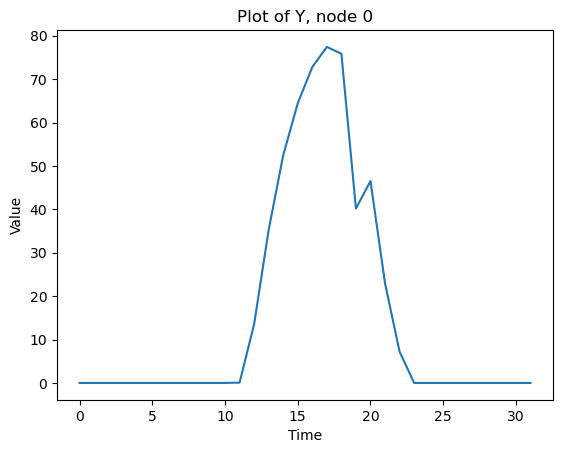

In [180]:
node_id = 0

plt.plot(Y[:32, node_id].cpu().detach().numpy())
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Plot of Y, node {node_id}')
plt.show()


In [181]:
output = loaded_model(X).squeeze()

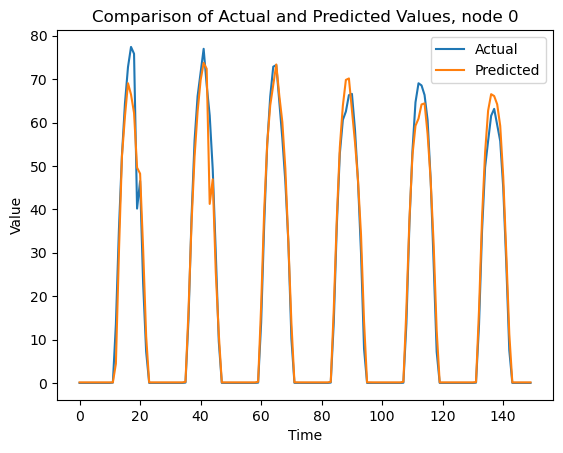

In [182]:
node_id = 0

plt.plot(Y[:150,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:150,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

In [183]:
torch.save({'Y': Y, 'states': X}, 'KOP/DynGESN/states.pt')

# DMD

In [54]:
from DMD.dmd import KANN

In [184]:
Y, states = torch.load('KOP/DynGESN/states.pt').values()

In [185]:
states.shape

torch.Size([864, 200, 170])

In [186]:
node_id = 0
norms = []
for i in range(10):
    norms.append(torch.linalg.vector_norm(states[:-1,i+node_id,:]-states[1:,i+node_id,:], dim=(1)))

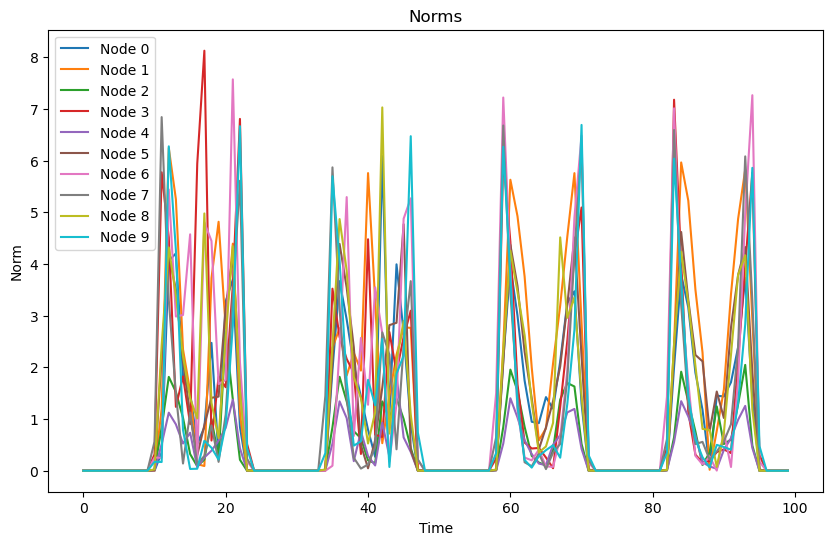

In [190]:
plt.figure(figsize=(10, 6))

for i, norm in enumerate(norms):
    plt.plot(norm.cpu().detach()[:100], label=f'Node {i+node_id}')

plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norms')
plt.legend()
plt.show()

Global Koopman analysis at a node level

In [195]:
states.shape

torch.Size([200, 864, 170])

In [192]:
dim_red = 50
method = None #'TruncatedSVD'

# compute local Koopman operator
states = rearrange(states, 't n f -> n t f')
kann_ = KANN(states.cpu(), k=dim_red, emb=method)

In [193]:
K = kann_.compute_KOP()

In [194]:
K.shape

(170, 170)

Reconstruct trajectories

In [196]:
states = rearrange(states, 'n t f -> t n f')

In [197]:
n_states = []
s = states[0,:,:].cpu()

for t in range(states.shape[0]):
    n_states.append(s)
    s = s @ K

n_states = torch.stack(n_states, dim=0)

In [198]:
norm = torch.linalg.vector_norm(states[:,:,:].cpu()-n_states, dim=(1,2))

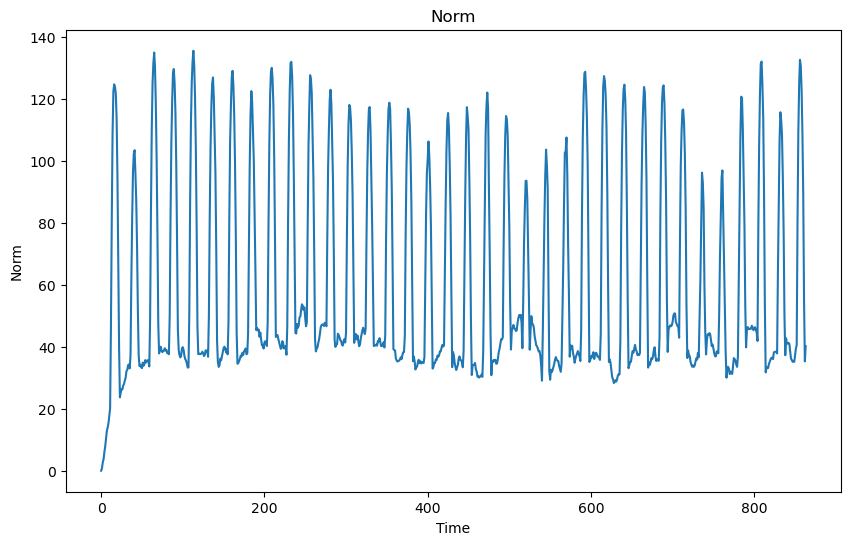

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(norm.cpu().detach())
plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norm')
plt.show()

In [200]:
output = loaded_model(n_states.to(device)).squeeze()

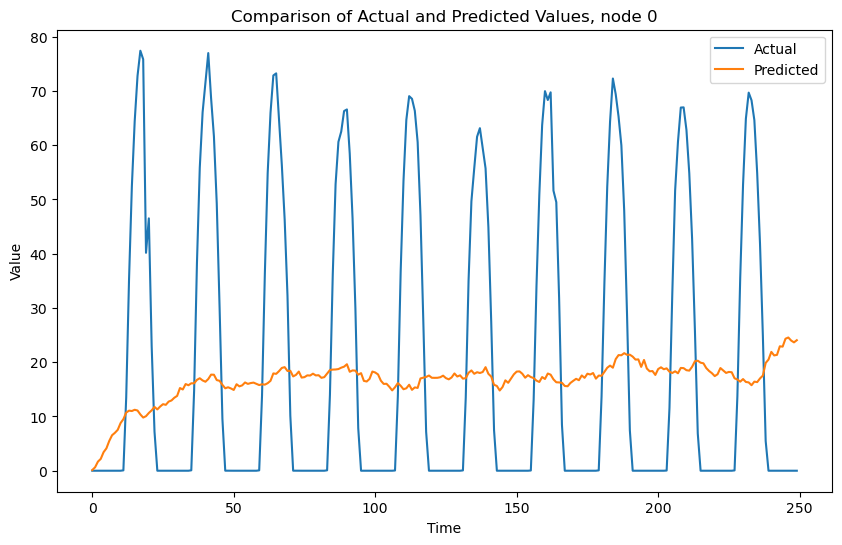

In [201]:
node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:250,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:250,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

Project status of a node on most important eigenvalues and check what patterns is reflected more on which eigenspace

In [202]:
E_global, V_global = np.linalg.eig(K)

idx = E_global.argsort()[::-1]   
E_global = E_global[idx]
V_global = V_global[:,idx]

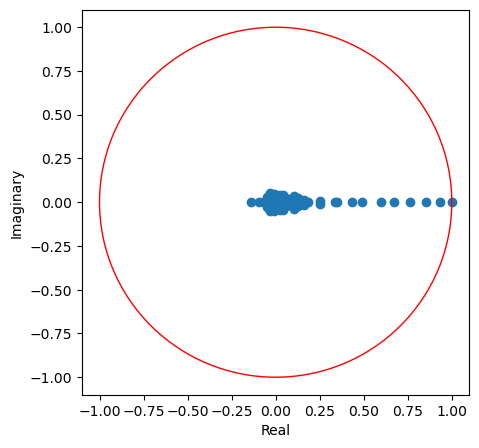

In [203]:
plt.figure(figsize=(5,5))
plt.scatter(E_global.real, E_global.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

In [204]:
states.shape

torch.Size([864, 200, 170])

In [205]:
proj_state0 = (states.cpu() @ V_global[:,0]).real # it's real anyway
proj_state1 = (states.cpu() @ V_global[:,1]).real # it's real anyway

In [206]:
proj_state0.shape

torch.Size([864, 200])

In [207]:
proj_states = torch.zeros_like(states.cpu())

for i in range(proj_state0.shape[0]):
    for j in range(proj_state0.shape[1]):
        proj_states[i,j,:] = proj_state0[i,j] * V_global[:,0] #+ proj_state1[i,j] * V_global[:,1]

In [208]:
proj_states.shape

torch.Size([864, 200, 170])

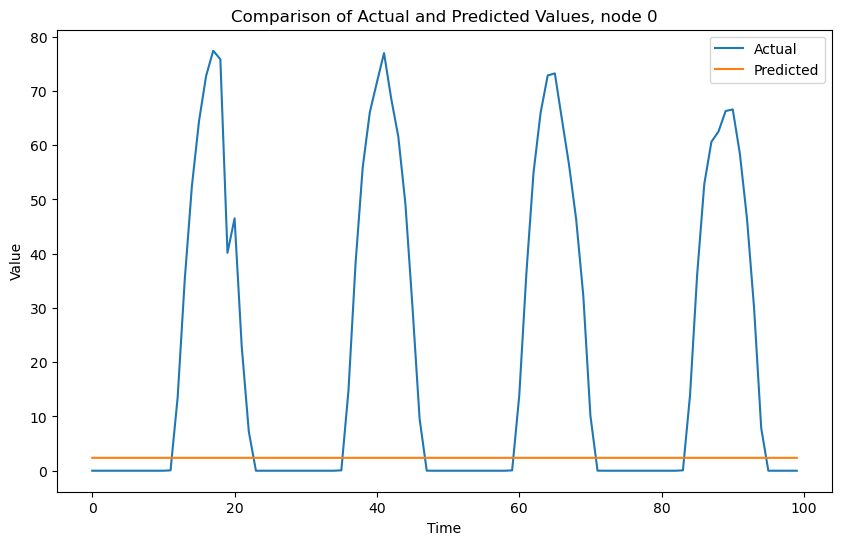

In [209]:
output = loaded_model(proj_states.to(device)).squeeze()

node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

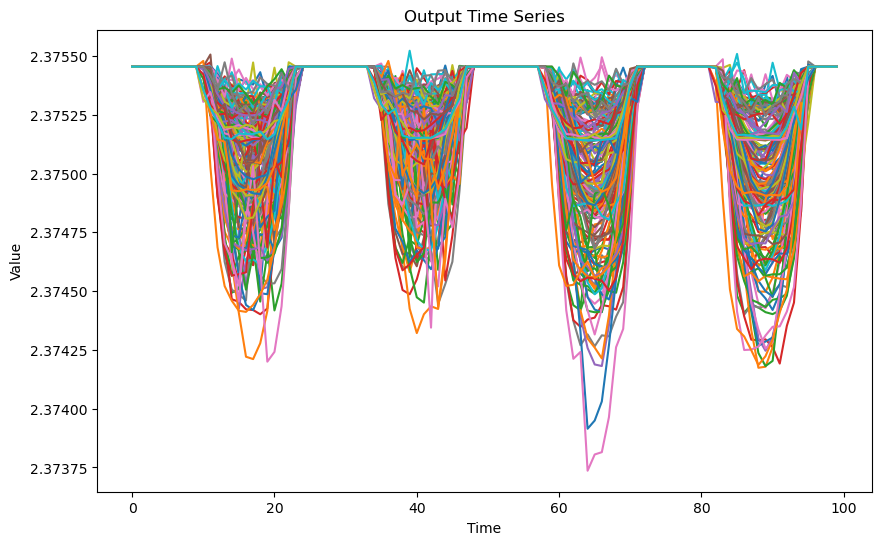

In [210]:
plt.figure(figsize=(10, 6))

for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())#, label=f'Time Series {i+1}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
# plt.legend()
plt.show()


Proiettare sul primo o i primi due autostati mostra pattern molto piccoli